# **Handwritten Signature Recognition**



In [ ]:
import os
import cv2
import csv
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.6.2', '1.20.3')

## Reading the Dataset
We're reading the folders and splitting them into train and test set for training purposes.

In [ ]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

ROOT = "/kaggle/input/cv-signature-dataset"

def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.resize(image,(256,256))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
label_dict = {}

# Loop through each person's folder
for person_folder in os.listdir(ROOT):
    # Check if folder is a directory (i.e., not a file)
    if os.path.isdir(os.path.join(ROOT, person_folder)):
        # Loop through each train/test folder
        for split_folder in ["Train", "Test"]:
            split_path = os.path.join(ROOT, person_folder, split_folder)
            if os.path.isdir(split_path):
                # Create dictionary for images in this split
                split_dict = {}
                
                label_file_name = person_folder + "_SigVerification" + split_folder.capitalize() + "Labels.csv"
                label_path = os.path.join(split_path, label_file_name)
                
                if os.path.exists(label_path):
                    with open(label_path, "r") as label_file:
                        csv_reader = csv.reader(label_file)
                        next(csv_reader) # skip first row
                        for row in csv_reader:
                            image_filename = row[0]
                            label_dict[image_filename] = row[1]

In [ ]:
print(len(label_dict))
print(label_dict)

240
{'personD_27.png': 'forged', 'personD_3.png': 'forged', 'personD_1.png': 'forged', 'personD_29.png': 'forged', 'personD_35.png': 'forged', 'personD_5.png': 'forged', 'personD_4.png': 'forged', 'personD_23.png': 'forged', 'personD_6.png': 'forged', 'personD_10.png': 'forged', 'personD_7.png': 'forged', 'personD_30.png': 'forged', 'personD_32.png': 'forged', 'personD_9.png': 'forged', 'personD_37.png': 'forged', 'personD_28.png': 'forged', 'personD_45.png': 'forged', 'personD_11.png': 'forged', 'personD_24.png': 'forged', 'personD_44.png': 'forged', 'personD_43.png': 'real', 'personD_8.png': 'real', 'personD_34.png': 'real', 'personD_2.png': 'real', 'personD_38.png': 'real', 'personD_18.png': 'real', 'personD_39.png': 'real', 'personD_25.png': 'real', 'personD_33.png': 'real', 'personD_19.png': 'real', 'personD_46.png': 'real', 'personD_48.png': 'real', 'personD_20.png': 'real', 'personD_42.png': 'real', 'personD_36.png': 'real', 'personD_47.png': 'real', 'personD_13.png': 'real', 'p

## Creating Triplets
We use the train and test list to create triplets of (anchor, postive, negative) Signature data, where positive is the same person and negative is a different Signature than anchor.

In [ ]:
def create_triplets(directory,label_dict, data_type):
    triplets = []
    folders = os.listdir(directory)
    
    for folder in folders:
        path = os.path.join(directory, folder,data_type)
        files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and f.lower().endswith(('.png'))]
        num_files = len(files)
        
        for i in range(num_files-1):
            for j in range(i+1, num_files-1):
                if label_dict[files[i]]=='real' and label_dict[files[j]]=='real':
                    k=-1
                    while True:
                        k=random.randint(0,num_files-1)
                        if label_dict[files[k]]=='forged':
                            break
                               
                    anchor = (os.path.join(folder,data_type),files[i])
                    positive = (os.path.join(folder,data_type),files[j])
                    negative = (os.path.join(folder,data_type),files[k])
                    triplets.append((anchor, positive, negative))
            
    random.shuffle(triplets)
    return triplets

In [ ]:
train_triplet = create_triplets(ROOT,label_dict, 'Train')
test_triplet  = create_triplets(ROOT,label_dict, 'Test')

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 912
Number of testing triplets : 21

Examples of triplets:
(('personE/Train', 'personE_9.png'), ('personE/Train', 'personE_5.png'), ('personE/Train', 'personE_41.png'))
(('personB/Train', 'personB_6.png'), ('personB/Train', 'personB_15.png'), ('personB/Train', 'personB_31.png'))
(('personA/Train', 'personA_7.png'), ('personA/Train', 'personA_43.png'), ('personA/Train', 'personA_21.png'))
(('personC/Train', 'personC_26.png'), ('personC/Train', 'personC_5.png'), ('personC/Train', 'personC_1.png'))
(('personD/Train', 'personD_12.png'), ('personD/Train', 'personD_47.png'), ('personD/Train', 'personD_4.png'))


## Creating Batch-Generator¶
Creating a Batch-Generator that converts the triplets passed into batches of Signature-data and preproccesses it before returning the data into seperate lists.

Parameters:

* Batch_size: Batch_size of the data to return
* Preprocess: Whether to preprocess the data or not

In [ ]:
def get_batch(triplet_list, batch_size=64, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

## Plotting the Data
Plotting the data generated from get_batch() to see the results

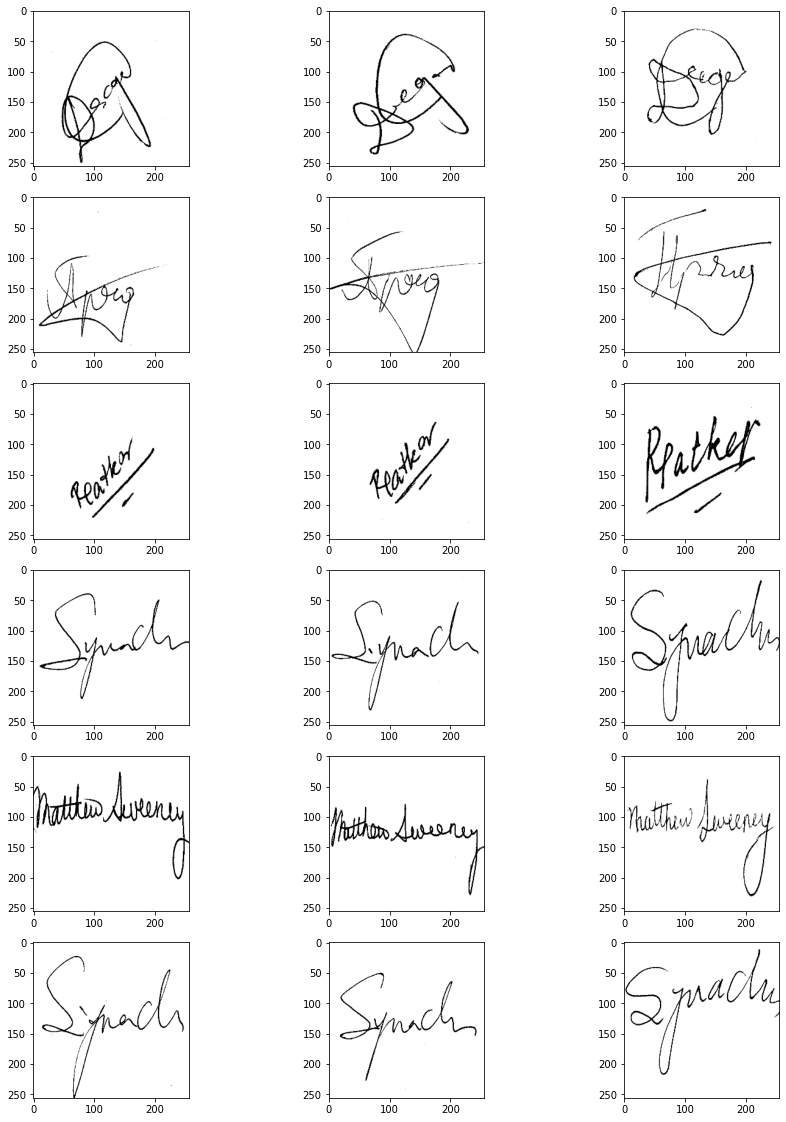

In [ ]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

## Creating the Model
Unlike a conventional CNN, the Siamese Network does not classify the images into certain categories or labels, rather it only finds out the distance between any two given images. If the images have the same label, then the network should learn the parameters, i.e. the weights and the biases in such a way that it should produce a smaller distance between the two images, and if they belong to different labels, then the distance should be larger

Siamese Network Image
![](https://miro.medium.com/max/2000/1*05hUCDHhnl4hdjqvdVTHtw.png)

In [ ]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Encoder
The Encoder is responsible for converting the passed images into their feature vectors. We're using a pretrained model, Xception model which is based on Inception_V3 model. By using transfer learning, we can significantly reduce the training time and size of the dataset.

The Model is connected to Fully Connected (Dense) layers and the last layer normalises the data using L2 Normalisation. (L2 Normalisation is a technique that modifies the dataset values in a way that in each row the sum of the squares will always be up to 1)

In [ ]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [ ]:
get_encoder((256,256,3))

83697664/83683744 [==============================] - 4s 0us/step


Siamese Network
We're creating a Siamese Network that takes 3 input images, (anchor, postive, negative) and uses the encoder above to encode the images to their feature vectors. Those features are passed to a distance layer which computes the distance between (anchor, positive) and (anchor, negative) pairs.

We'll be defining a custom layer to compute the distance.

Distance Formula:

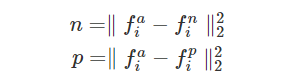

In [ ]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (256, 256, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Anchor_Input (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Positive_Input (InputLayer)     [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Negative_Input (InputLayer)     [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Encode_Model (Sequential)       (None, 256)          22043944    Anchor_Input[0][0]               
                                                                 Positive_Input[0][0

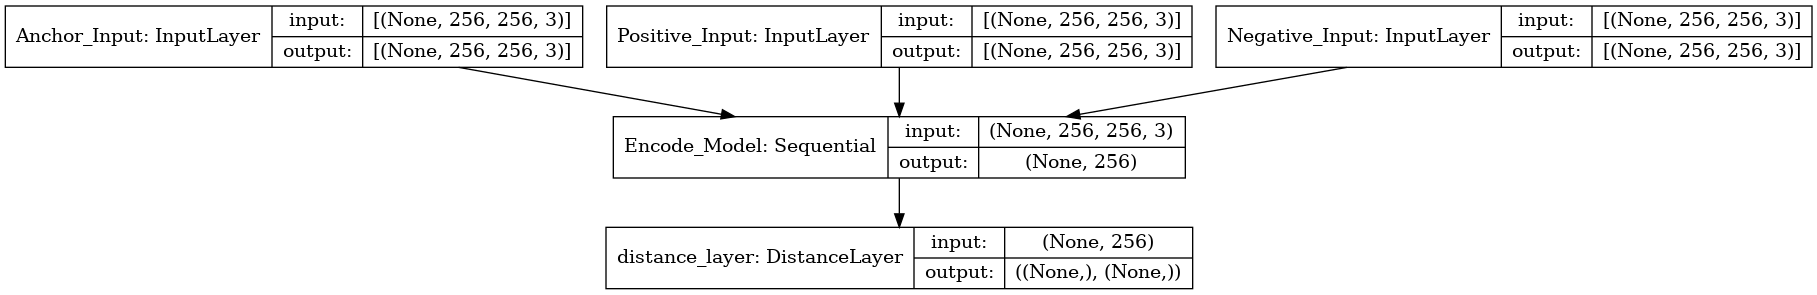

In [ ]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

## Putting everything together
We now need to implement a model with custom training loop and loss function so we can compute the triplet loss using the three embeddings produced by the Siamese network.

We'll create a Mean metric instance to track the loss of the training process.

Triplet Loss Function:

### ![](https://miro.medium.com/max/1838/0*AX2TSZNk19_gDgTN.png)

In [ ]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

## Training the Model
We'll now be training the siamese_model on batches of triplets. We'll print the training loss, along with additional metrics from testing every epoch. The model weights will also be saved whenever it outperforms the previous max_accuracy.

We're hoping to collect more metrics about the model to evaluate how to increase the accuracy of the model. The epochs have been set to avoid going over Kaggle's time constraint.

### Test Function
test_on_triplets() function will be responsible for testing the model on test_triplets. It'll collect metrics (accuracy, means, stds) by predicting on the train data. We'll also be printing the Accuracy of the model after testing.

In [ ]:
def test_on_triplets(batch_size = 64):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [ ]:
save_all = False
epochs = 6
batch_size = 64

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")


EPOCH: 1 	 (Epoch done in 44 sec)
Loss on train    = 0.44610
Accuracy on test = 0.95238

EPOCH: 2 	 (Epoch done in 23 sec)
Loss on train    = 0.00382
Accuracy on test = 1.00000

EPOCH: 3 	 (Epoch done in 23 sec)
Loss on train    = 0.00372
Accuracy on test = 1.00000

EPOCH: 4 	 (Epoch done in 24 sec)
Loss on train    = 0.00119
Accuracy on test = 1.00000

EPOCH: 5 	 (Epoch done in 23 sec)
Loss on train    = 0.00010
Accuracy on test = 1.00000

EPOCH: 6 	 (Epoch done in 23 sec)
Loss on train    = 0.00000
Accuracy on test = 1.00000


## Using the Model
Now that we've finished training our model, we need to extract the encoder so that we can use it to encode images and then get use the feature vectors to compute the distance between those images.

We'll also be saving the encoder for later use.

In [ ]:
def extract_encoder(model):
    encoder = get_encoder((256, 256, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_14 (Batc (None, 512)               2048      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
lambda_2 (Lambda)            (None, 256)               0         
Total params: 22,043,944
Trainable params: 9,583,800
Non-trainable params: 12,460,144
__________________________________

## Classify Images
To compute the distance between the encodings of the images, we'll be using distance formula. Distance over a certain threshold to be "different" and below the threshold as "same".

In [ ]:
def classify_images(Signature1, Signature2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(Signature1)
    tensor2 = encoder.predict(Signature2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction


Accuracy of model: 0.9761904761904762



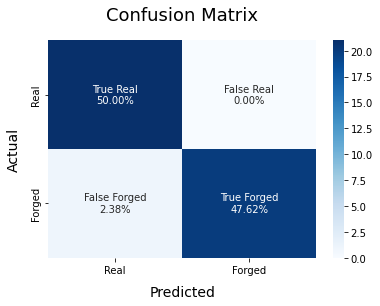

In [ ]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Real','Forged']
    names = ['True Real','False Real', 'False Forged','True Forged']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=64):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)

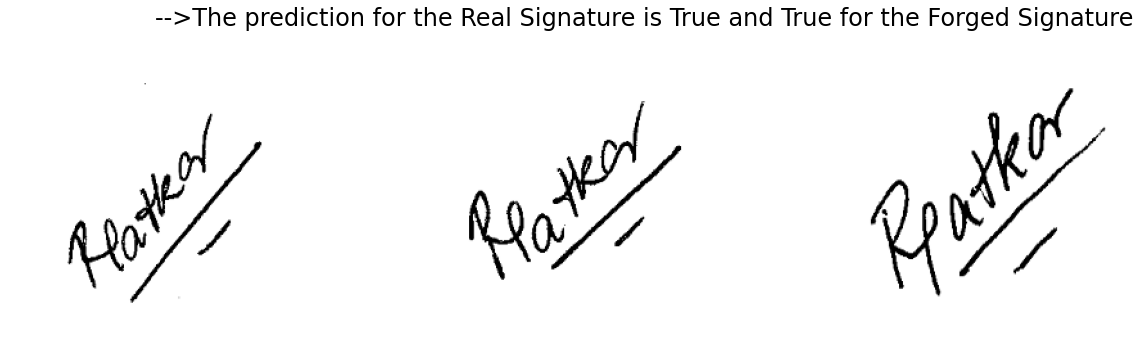

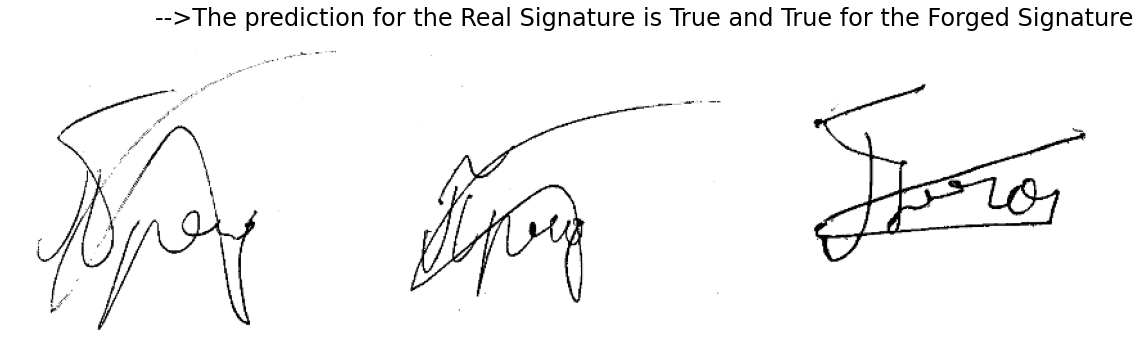

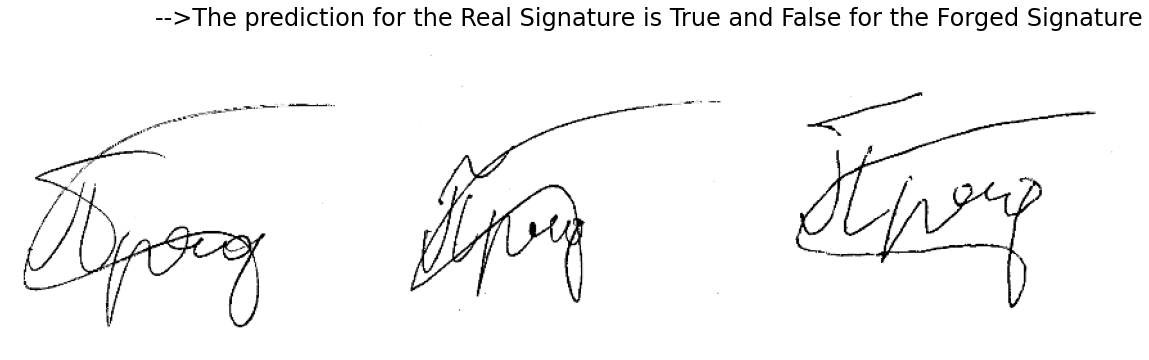

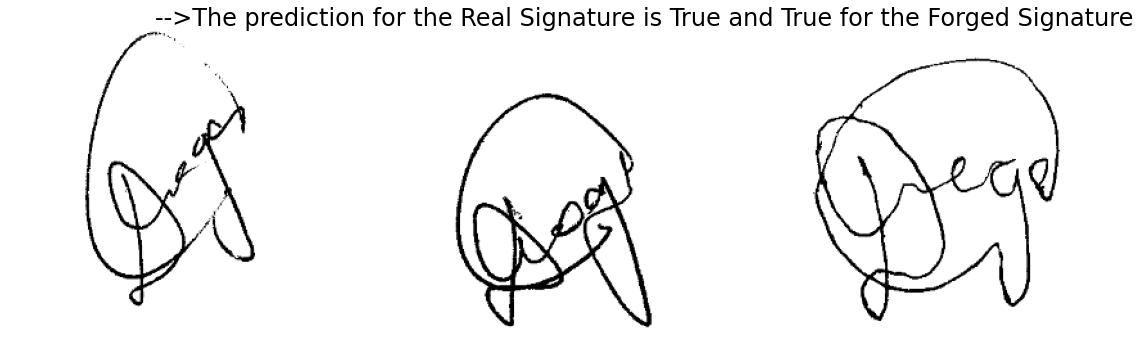

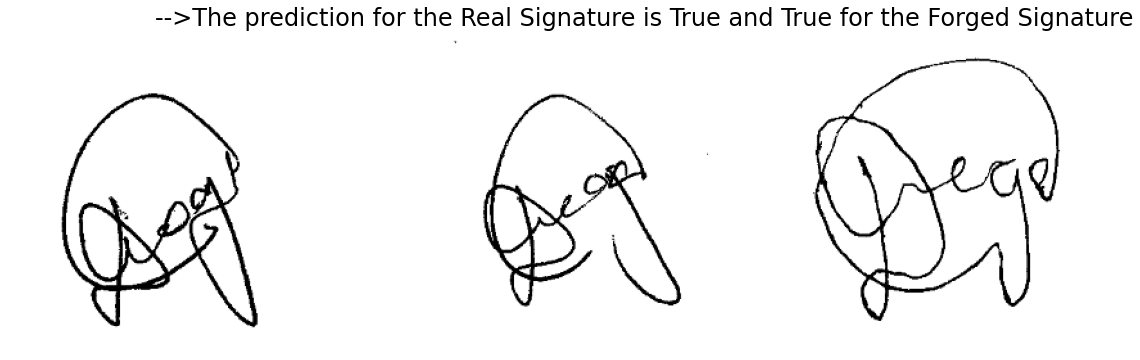

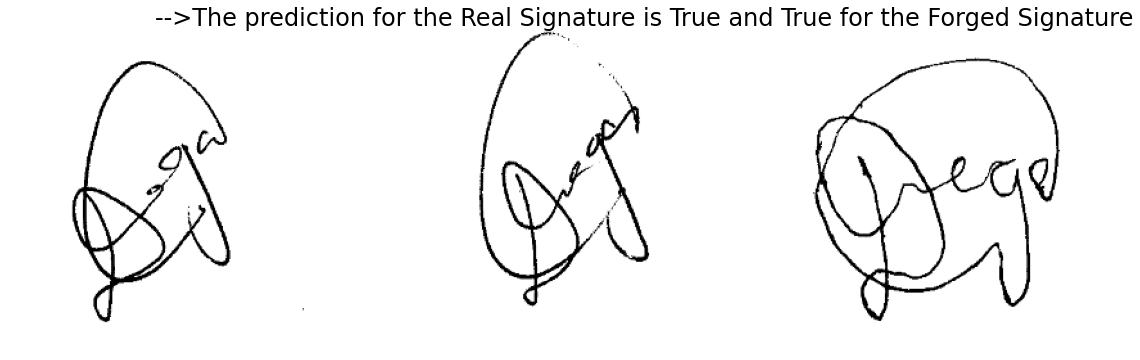

In [ ]:
num_plots=6
for i in range(num_plots):
    a,p,n=test_triplet[i]
    posp='True' if pos_list[i]==0 else 'False'
    negp='True' if neg_list[i]==1 else 'False'
    s=f'-->The prediction for the Real Signature is {posp} and {negp} for the Forged Signature'
    plt.figure(figsize=(20, 20))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(read_image(a))
    plt.axis('off')

    ax = plt.subplot(1, 3, 2)
    plt.imshow(read_image(p))
    plt.axis('off')
    ax = plt.subplot(1, 3, 3)
    plt.imshow(read_image(n))
    plt.axis('off')
    plt.text(-500,0, s, fontsize=24)
    plt.show()

# **Handwritten Signature Detection**

## **Set Up The Yolov7**

In [1]:
!git clone https://github.com/WongKinYiu/yolov7.git

Cloning into 'yolov7'...
remote: Enumerating objects: 1154, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 1154 (delta 8), reused 13 (delta 7), pack-reused 1139
Receiving objects: 100% (1154/1154), 70.42 MiB | 27.47 MiB/s, done.
Resolving deltas: 100% (496/496), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Prepare The Data**

In [8]:
import os

# Define the two folders to loop through
TrainGroundTruth_path = '/content/drive/MyDrive/SignatureObjectDetection/TrainGroundTruth'
TestGroundTruth_path = '/content/drive/MyDrive/SignatureObjectDetection/TestGroundTruth'
img_width = 1000
img_height = 1000
# Define a function to convert (x1, y1, x2, y2) format to YOLOv7 format
def convert_to_yolov7(x1, y1, x2, y2, img_width, img_height):
    # Calculate the center coordinates of the bounding box
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2

    # Calculate the width and height of the bounding box
    width = x2 - x1
    height = y2 - y1

    # Normalize the coordinates and dimensions by the image size
    center_x = center_x / img_width
    center_y = center_y / img_height
    width = width / img_width
    height = height / img_height

    return center_x, center_y, width, height


# Loop through each file in the two folders
for folder_path in [TrainGroundTruth_path, TestGroundTruth_path]:
    for file_name in os.listdir(folder_path):
        # Skip non-text files
        if not file_name.endswith('.txt'):
            continue

        # Open the text file and read the lines
        with open(os.path.join(folder_path, file_name), 'r') as f:
            lines = f.readlines()

        # Update the annotations in each line
        updated_lines = []
        for line in lines:
            # Split the line into its components
            components = line.strip().split(',')
            x1, y1, x2, y2 = map(float, components[:4])
            
            # Convert the annotation to YOLOv7 format
            center_x, center_y, width, height = convert_to_yolov7(x1, y1, x2, y2, img_width, img_height)

            # Update the line with the new annotation and add it to the list of updated lines
            components[0] = '0'
            components[1] = str(center_x)
            components[2] = str(center_y)
            components[3] = str(width)
            components.append(str(height))
            updated_line = ' '.join(components) + '\n'
            updated_lines.append(updated_line)

        # Write the updated lines back to the file
        with open(os.path.join(folder_path, file_name), 'w') as f:
            f.writelines(updated_lines)

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths for data folders
train_images_path = '/content/drive/MyDrive/SignatureObjectDetection/TrainImages/'
train_gt_path = '/content/drive/MyDrive/SignatureObjectDetection/TrainGroundTruth/'
train_images_output_path = '/content/drive/MyDrive/SignatureObjectDetection/train_images/'
val_images_output_path = '/content/drive/MyDrive/SignatureObjectDetection/val_images/'
train_gt_output_path = '/content/drive/MyDrive/SignatureObjectDetection/train_gt/'
val_gt_output_path = '/content/drive/MyDrive/SignatureObjectDetection/val_gt/'

# Get list of image files in TrainImages folder
image_files = os.listdir(train_images_path)

# Split images into training and validation sets
train_files, val_files = train_test_split(image_files, test_size=0.2)

# Copy training set images and ground truth files to new folders
for train_file in train_files:
    # Check if image file exists
    if os.path.exists(train_images_path + train_file):
        # Copy image file
        shutil.copy2(train_images_path + train_file, train_images_output_path + train_file)

        # Check if ground truth file exists
        gt_file = train_file.split('.')[0] + '.txt'
        if os.path.exists(train_gt_path + gt_file):
            # Copy corresponding ground truth file to train_gt folder
            shutil.copy2(train_gt_path + gt_file, train_gt_output_path + gt_file)
        else:
            print(f'Warning: Ground truth file {gt_file} not found for image {train_file}. Skipping.')

    else:
        print(f'Warning: Image file {train_file} not found. Skipping.')

# Copy validation set images and ground truth files to new folders
for val_file in val_files:
    # Check if image file exists
    if os.path.exists(train_images_path + val_file):
        # Copy image file
        shutil.copy2(train_images_path + val_file, val_images_output_path + val_file)

        # Check if ground truth file exists
        gt_file = val_file.split('.')[0] + '.txt'
        if os.path.exists(train_gt_path + gt_file):
            # Copy corresponding ground truth file to val_gt folder
            shutil.copy2(train_gt_path + gt_file, val_gt_output_path + gt_file)
        else:
            print(f'Warning: Ground truth file {gt_file} not found for image {val_file}. Skipping.')

    else:
        print(f'Warning: Image file {val_file} not found. Skipping.')


In [6]:
import os
import shutil

# Define the source and destination directories
source_dir = '/content/drive/MyDrive/SignatureObjectDetection'
dest_dir = '/content/yolov7/data'

# Create the Train, Test, and Validation directories
os.makedirs(os.path.join(dest_dir, 'Train', 'images'))
os.makedirs(os.path.join(dest_dir, 'Train', 'labels'))
os.makedirs(os.path.join(dest_dir, 'Test', 'images'))
os.makedirs(os.path.join(dest_dir, 'Test', 'labels'))
os.makedirs(os.path.join(dest_dir, 'Validation', 'images'))
os.makedirs(os.path.join(dest_dir, 'Validation', 'labels'))

# Move the train images and labels to the Train directory
for filename in os.listdir(os.path.join(source_dir, 'train_images')):
    if filename.endswith('.tif'):
        shutil.move(os.path.join(source_dir, 'train_images', filename), os.path.join(dest_dir, 'Train', 'images', filename))
for filename in os.listdir(os.path.join(source_dir, 'train_gt')):
    if filename.endswith('.txt'):
        shutil.move(os.path.join(source_dir, 'train_gt', filename), os.path.join(dest_dir, 'Train', 'labels', filename))

# Move the test images and labels to the Test directory
for filename in os.listdir(os.path.join(source_dir, 'TestImages')):
    if filename.endswith('.tif'):
        shutil.move(os.path.join(source_dir, 'TestImages', filename), os.path.join(dest_dir, 'Test', 'images', filename))
for filename in os.listdir(os.path.join(source_dir, 'TestGroundTruth')):
    if filename.endswith('.txt'):
        shutil.move(os.path.join(source_dir, 'TestGroundTruth', filename), os.path.join(dest_dir, 'Test', 'labels', filename))

# Move the validation images and labels to the Validation directory
for filename in os.listdir(os.path.join(source_dir, 'val_images')):
    if filename.endswith('.tif'):
        shutil.move(os.path.join(source_dir, 'val_images', filename), os.path.join(dest_dir, 'Validation', 'images', filename))
for filename in os.listdir(os.path.join(source_dir, 'val_gt')):
    if filename.endswith('.txt'):
        shutil.move(os.path.join(source_dir, 'val_gt', filename), os.path.join(dest_dir, 'Validation', 'labels', filename))


## **Custom Training**

In [9]:
%cd yolov7

[Errno 2] No such file or directory: 'yolov7'
/content/yolov7


In [10]:
!python train.py --workers 1 --device 0 --batch-size 8 --data data/coco.yaml --img 1000 1000 --cfg cfg/training/yolov7.yaml --weights '' --name yolov7 --hyp data/hyp.scratch.p5.yaml

2023-05-09 07:10:28.795793: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 07:10:30.751867: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Namespace(weights='', cfg='cfg/training/yolov7.yaml', data='data/coco.yaml', hyp='data/hyp.scratch.p5.yaml', epochs=300, batch_size=8, img_size=[1000, 1000], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='0', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=1, project='runs/train', entity=None, name='yolov7', exist_ok=False, quad=False, linear_lr

## **Evaluation**

In [17]:
!python detect.py --weights /content/yolov7/runs/train/yolov72/weights/best.pt --conf 0.1 --img-size 640 --source /content/drive/MyDrive/SignatureObjectDetection/val_images/276.tif --no-trace

Namespace(weights=['/content/yolov7/runs/train/yolov72/weights/best.pt'], source='/content/drive/MyDrive/SignatureObjectDetection/val_images/276.tif', img_size=640, conf_thres=0.1, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=True)
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36481772 parameters, 6194944 gradients
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Done. (21.9ms) Inference, (0.5ms) NM